In This Problem, We want to investigate the minimum vertex cover problem. Informally, A vertex cover is a subset of vertices that cover all the edges. i.e., for each edge, there exists an endpoint in the vertex cover. A minimum vertex cover is a vertex cover with the least amount of vertices possible.


The Formal definition of the problem is as follows:
A vertex cover $V'$ of an undirected graph $G = (V,E)$ is a subset of $V$ such that for all edge $uv \in E \Rightarrow u \in V' \vee v \in V'$. The vertex cover with the smallest possible size is called the minimum vertex cover.

Minimum vertex cover is a famous NP-Hard optimization problem. It means that we currently don't have any polynomial-time algorithm for this problem, and we will most likely never have such an algorithm unless $P = NP$. Therefore it is reasonable to use optimization algorithms like local search to find an approximate but not necessarily perfect answer.

In this question and the next one, you should implement two different local search techniques to solve this problem: Simulated Annealing for this question and the Genetic Algorithm for the next one.

In this problem, we provide you some of the functions to solve the problem. Some of them are complete, but some are incomplete, and you should complete them.

## Libraries

In [ ]:
import numpy as np
from math import exp
import random
import matplotlib.pyplot as plt
import math

## Graph Data
There is a file named **create_graph.py** beside this jupyter notebook. You can generate multiple types of networks by running the file using the syntax below. It is **not** mandatory and does not have any additional score. It is just for you to test your code to see whether it works or not.
```
python create_graph.py
```
Make sure that you have the dependencies installed, especially networkx version: 2.5.1+. You can use `pip`  to install the newest version of networkx using
```
pip install networkx
```
Also, you may want to change variables m2n and n in `create_graph.py`.

n is the number of nodes. m2n is roughly equal to the number of edges divided by the number of nodes.
 

## Reading graph data

We provide graph data in '.txt' files as an adjacency matrix. The first line indicates $n$, the number of vertices. The following $n$ lines each contain $n$ comma-separated numbers. Consider $d_{ij}$ to be the number in $i$th row and $j$th column. It is $1$ if and only if there is an edge between node $i$ and $j$, and $0$ otherwise. The function is provided completely for your comfort, and you don't need to change it.

In [ ]:
"""
No need to change this cell. You can change "./Inputs/test-q3-q4.txt" to test different graphs.
"""

graph_matrix =[]
def load_data(path = "./Inputs/test-q3-q4.txt"):
    with  open(path , 'r') as f:
        lines = f.readlines()
        number_of_vertices = int(lines[0])
        for i in range(number_of_vertices):
            line_split = lines[i+1].split(',');
            graph_matrix.append([])
            for j in range(number_of_vertices):
                graph_matrix[i].append(int(line_split[j]))
load_data()

## Edge Count

In [ ]:
edge_count = np.sum(graph_matrix)//2
print(edge_count)

23191


## State

To use local search algorithms, we must define our state-space. As the problem is about choosing a vertex or not, we define each state as a vector $S$ of size $n$. 

$$
S_i=   \left\{
\begin{array}{ll}
      0 & \text{vertex $v_i$ is not in vertex cover} \\
      1 & \text{vertex $v_i$ is in vertex cover}
\end{array} 
\right.
$$

Write a function that generates a random state. i.e., it must return a boolean vector of size $n$.

In [ ]:
def random_state_generator(n):
    v = np.random.randint(0, 2,(n))
    return v

We must also define the neighbor state. We can use multiple definitions for neighbor states, But here we use a simple one. Two states are neighbors if and only if they differ in just one element. Complete the following function, which gets a state and returns a new state by randomly choosing one element in the previous state and changing it from $0$ to $1$ or $1$ to $0$.

It is strongly recommended that you return the index of the changed element and its value, as you will likely need that later.

In [ ]:
def neighbour_state_generator(state):
    new_state = state.copy()
    n = len(state)
    vertex_to_change = np.random.randint(0, n)
    previous_value = state[vertex_to_change]
    new_state[vertex_to_change] = 1 -  state[vertex_to_change]
    return new_state, previous_value, vertex_to_change

## Cost Function

We must also define a cost function to evaluate each state. There are many ways to define a cost function for the vertex cover problem. Here we propose a cost function that works well with the problem. You could use other cost functions if you believe they work better. 

Our Proposed cost function is:

$C(s)=A*\sum_{i=1}^{n} s_{i}+ B*\sum_{i=1}^{n} \sum_{j=1}^{n} \mathrm{~d}_{i j} \overline{s_{i} \vee s_{j}}$

Here, $s_i$ is the $i\text{th}$ element of state vector. $\overline{s_{i} \vee s_{j}}$ is logical NOR of $v_i$ and $v_j$.

$A$ and $B$ are two arbitrary constants. Usually $A=1$ and $B=1$, but you could use other values.

Note that the formula above uses a 1-based index as a mathematical equation, but Python uses a 0-based index.

In [ ]:
def cost_function(graph_matrix,state , A = 1 , B=5):
    cost = 0;
    n = len(state)
    cost += A*np.sum(state)
    Nor_Mat = np.ones((n,n))
    for i in range(n):
        if (state[i] == 1): 
                Nor_Mat[i,:] = 0
                Nor_Mat[:,i] = 0
    cost += B*np.sum(Nor_Mat*graph_matrix)
    return cost

## Simulated Annealing

Now comes the central part. Simulated annealing is somehow like normal hill-climbing, but with a small but significant change. In each iteration of Simulated Annealing, we calculate the cost of this new state after generating a neighbor state. If it is better than the current state, we accept it and use it as the new current state. But if it is worse than the current state, we calculate an acceptance probability and accept it based on this probability.

Usually, $P = e^{-\frac{\Delta C}{T}}$ is used for acceptance probability, in which $\Delta C$ is the cost difference between the new state and previous state. $T$ is a positive parameter called Temperature. At first, it is initialized based on the problem domain. After each iteration, it is multiplied by a factor of $\alpha<1$ to make it smaller. The point of using $T$ is to allow more random perturbations at the start of the algorithm to prevent getting stuck in a local extremum.

For the vertex cover problem, there exist better acceptance probability equations. We consider one here, but you are free to use other equation.




### Vertex Cover Probability Acceptance Equation

Let $s$ be current state and $s'$ be a neighbour state that has worse cost function that $s$. Also suppose that only $i$th element is different between $s$ and $s'$. For calculating acceptance probability of $s'$ we use this equation: 


$$p= \begin{cases}\mathrm{e}^{-\frac{\Delta F\left(1-D e g\left(s_{i}\right)\right)}{T}} & s_{i}=1 \\ \mathrm{e}^{-\frac{\Delta F\left(1+D e g\left(s_{i}\right)\right)}{T}} & s_{i}=0\end{cases}$$
in which
$$\operatorname{Deg}\left({i}\right)=\frac{\operatorname{Degree}(i)}{E d g e N u m}$$

Note that $Deg(s_i)$ is actually independent of state and can be calculated beforehand for each vertex.

Complete the line bellow the make an array named 'deg', in which $i$th element corresponds to $Deg(i)$

In [ ]:
deg = np.sum(graph_matrix,axis=0)/edge_count

Now complete the function 'prob_accept' that gets current and next state costs and other related information and returns the probability of acceptance of the next state.

In [ ]:
def prob_accept(c0,c1,state,T,deg,vertex_to_change): 
    delat_c = c1-c0
    if state[vertex_to_change]==1:
        p = exp(-delat_c*(1-deg[vertex_to_change])/T)
    else:
        p = exp(-delat_c*(1+deg[vertex_to_change])/T)
    return p

Now Implement a function called 'accept'. This function gets the current state and next state and other required parameters as input and outputs True or False to identify whether we should accept the next state or not.

In [ ]:
def accept(current_state,next_state,graph_matrix,T,deg,vertex_to_change):
    c0 = cost_function(graph_matrix,current_state)
    c1 = cost_function(graph_matrix,next_state) 
    if c1 < c0 :
        return True
    else: 
        p = prob_accept(c0,c1,current_state,T,deg,vertex_to_change)
        res = np.random.binomial(1, p, 1)   
        if res == 1:
            return True
        return False

Now Implement the main 'anneal' function that performs the algorithm. Try to experiment with different initial T and $alpha$ values to get the best result. Also, your function must implement these two stop criteria:

- If the number of iterations exceeded 'stopping_iter', stop.
- If the temperature drops below 'stopping_temprature', stop.

Also, the cost_list array is defined before the function. Append the cost of the best solution found after each iteration to this array. Also, print out the best solution and the best cost obtained.

In [ ]:
cost_list = []


def anneal(
    graph_matrix, stopping_temperature=1e-8, stopping_iter=2000, alpha=0.999, T=70
):
    counter = 0
    n = np.size(graph_matrix,axis=0)
    current_state = random_state_generator(n)
    cost_list.append(cost_function(graph_matrix,current_state))
    edge_count = np.sum(graph_matrix)//2
    deg = np.sum(graph_matrix,axis=0)/edge_count
    while(1):
        state1 = T<=stopping_temperature
        state2 = counter>=stopping_iter
        if state1 or state2:
            break
        next_state, previous_value, vertex_to_change = neighbour_state_generator(current_state)
        res = accept(current_state,next_state,graph_matrix,T,deg,vertex_to_change)
        if res == True: 
            current_state = next_state
        T = T * 0.99
        counter += 1
        cost_list.append(cost_function(graph_matrix,current_state))
        print(counter,cost_list[-1])
    best_solution = current_state
    best_cost = cost_function(graph_matrix,current_state)
    print(T)
    print(counter)
    return best_solution, best_cost

In [ ]:
best_sol_SA, best_cost_SA = anneal(
    graph_matrix,
)

1 58499.0
2 58499.0
3 58499.0
4 58499.0
5 58080.0
6 58080.0
7 58080.0
8 58080.0
9 57591.0
10 57182.0
11 56783.0
12 56783.0
13 56394.0
14 56394.0
15 56394.0
16 55865.0
17 55865.0
18 55865.0
19 55865.0
20 55386.0
21 54917.0
22 54917.0
23 54917.0
24 54917.0
25 54917.0
26 54518.0
27 54518.0
28 54029.0
29 53630.0
30 53630.0
31 53630.0
32 53171.0
33 52722.0
34 52722.0
35 52263.0
36 51864.0
37 51864.0
38 51864.0
39 51864.0
40 51864.0
41 51864.0
42 51864.0
43 51864.0
44 51864.0
45 51355.0
46 51355.0
47 51355.0
48 50916.0
49 50477.0
50 50477.0
51 50477.0
52 50048.0
53 50048.0
54 49669.0
55 49250.0
56 48771.0
57 48412.0
58 48412.0
59 48412.0
60 47973.0
61 47973.0
62 47584.0
63 47584.0
64 47584.0
65 47584.0
66 47584.0
67 47584.0
68 47584.0
69 47215.0
70 46746.0
71 46277.0
72 46277.0
73 45918.0
74 45918.0
75 45439.0
76 44990.0
77 44990.0
78 44990.0
79 44551.0
80 44551.0
81 44122.0
82 43673.0
83 43673.0
84 43673.0
85 43673.0
86 43254.0
87 42875.0
88 42875.0
89 42875.0
90 42875.0
91 42506.0
92 42506

716 3571.0
717 3571.0
718 3502.0
719 3502.0
720 3413.0
721 3413.0
722 3413.0
723 3413.0
724 3334.0
725 3265.0
726 3265.0
727 3265.0
728 3265.0
729 3265.0
730 3176.0
731 3176.0
732 3176.0
733 3176.0
734 3117.0
735 3117.0
736 3117.0
737 3117.0
738 3117.0
739 3117.0
740 3117.0
741 3117.0
742 3117.0
743 3117.0
744 3117.0
745 3117.0
746 3117.0
747 3117.0
748 3117.0
749 3117.0
750 3117.0
751 3117.0
752 3117.0
753 3117.0
754 3117.0
755 3117.0
756 3117.0
757 3117.0
758 3117.0
759 3117.0
760 3117.0
761 3117.0
762 3117.0
763 3117.0
764 3117.0
765 3117.0
766 3117.0
767 3117.0
768 2988.0
769 2988.0
770 2988.0
771 2988.0
772 2988.0
773 2988.0
774 2988.0
775 2988.0
776 2988.0
777 2988.0
778 2988.0
779 2988.0
780 2988.0
781 2988.0
782 2988.0
783 2988.0
784 2988.0
785 2988.0
786 2988.0
787 2988.0
788 2988.0
789 2988.0
790 2929.0
791 2820.0
792 2820.0
793 2820.0
794 2820.0
795 2711.0
796 2711.0
797 2662.0
798 2662.0
799 2662.0
800 2662.0
801 2662.0
802 2662.0
803 2662.0
804 2662.0
805 2662.0
806 2662.0

1444 790.0
1445 790.0
1446 790.0
1447 790.0
1448 790.0
1449 790.0
1450 790.0
1451 790.0
1452 790.0
1453 790.0
1454 790.0
1455 790.0
1456 790.0
1457 790.0
1458 790.0
1459 790.0
1460 790.0
1461 761.0
1462 761.0
1463 761.0
1464 761.0
1465 761.0
1466 761.0
1467 761.0
1468 761.0
1469 761.0
1470 761.0
1471 761.0
1472 761.0
1473 761.0
1474 761.0
1475 761.0
1476 761.0
1477 761.0
1478 761.0
1479 761.0
1480 761.0
1481 761.0
1482 761.0
1483 761.0
1484 761.0
1485 761.0
1486 722.0
1487 722.0
1488 722.0
1489 722.0
1490 722.0
1491 722.0
1492 722.0
1493 722.0
1494 722.0
1495 722.0
1496 722.0
1497 722.0
1498 722.0
1499 722.0
1500 722.0
1501 722.0
1502 722.0
1503 722.0
1504 722.0
1505 722.0
1506 722.0
1507 722.0
1508 722.0
1509 722.0
1510 722.0
1511 722.0
1512 722.0
1513 722.0
1514 722.0
1515 722.0
1516 722.0
1517 722.0
1518 722.0
1519 722.0
1520 722.0
1521 722.0
1522 722.0
1523 722.0
1524 722.0
1525 722.0
1526 722.0
1527 722.0
1528 722.0
1529 722.0
1530 722.0
1531 722.0
1532 722.0
1533 722.0
1534 722.0

Plot the cost vs. iteration graph.

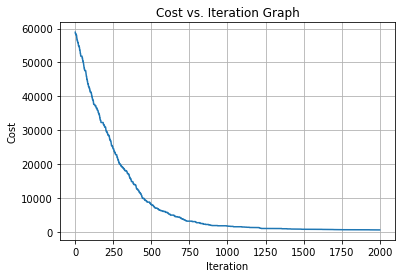

In [ ]:
def plot_cost(cost_list):
    plt.plot(cost_list)
    plt.ylabel('Cost')
    plt.xlabel('Iteration')
    plt.grid(True)
    plt.title( 'Cost vs. Iteration Graph')
    pass

plot_cost(cost_list)